In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import os
import math

In [8]:
#where all the host folders and the jsons live
main_folder = './canineH3N2'
host_folders = [folder for folder in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, folder))]

print(host_folders)
#what we are plotting
all_genes = []
all_hosts = []
all_slopes = [] #rate of adaptation
all_lower_95cis = []
all_upper_95cis = []


for host_folder in host_folders:
    host_path = os.path.join(main_folder, host_folder)
    json_files = [file for file in os.listdir(host_path) if file.endswith('.json')]
    for json_file in json_files:
        json_path = os.path.join(host_path, json_file)

        with open(json_path, 'r') as file:
            data = json.load(file)

        rate_of_adaptation = data["rate_of_adaptation"]
        bootstrap_rate_of_adaptation = data["bootstrap_rate_of_adaptation"]

        slope_sci = rate_of_adaptation * (10**3)
        bs_slope_sci = [x * (10**3) for x in bootstrap_rate_of_adaptation]
        lower_95ci = np.percentile(sorted(bs_slope_sci), 2.5)
        upper_95ci = np.percentile(sorted(bs_slope_sci), 97.5)

        all_genes.append(data['gene'].upper()) 
        all_hosts.append(data['host'].replace(' ', '\n')) 
        all_slopes.append(slope_sci)
        all_lower_95cis.append(lower_95ci)
        all_upper_95cis.append(upper_95ci)
        

#transforming data into df
all_data = {
    'gene': all_genes,
    'host': all_hosts,
    'adaptive_subs_per_codon_per_year': all_slopes,
    'lower_95ci': all_lower_95cis,
    'upper_95ci': all_upper_95cis,
    'ci': list(zip(all_lower_95cis, all_upper_95cis)),
}

df_all = pd.DataFrame(all_data)


['.ipynb_checkpoints', 'canineH3N2']


In [10]:
print(df_all)

  gene        host  adaptive_subs_per_codon_per_year  lower_95ci  upper_95ci  \
0   HA  canineH3N2                          0.988349    0.268621    1.872970   
1   NP  canineH3N2                         -0.034669   -0.232516    0.207724   
2   MP  canineH3N2                          2.834022    1.139715    4.308782   
3   NS  canineH3N2                          3.413604    1.685229    5.158764   
4  PB1  canineH3N2                          0.797783    0.169446    1.199294   
5   PA  canineH3N2                          0.775991    0.100983    1.513727   
6  PB2  canineH3N2                          0.873955    0.381913    1.427962   
7   NA  canineH3N2                          2.236683    1.228903    4.081956   

                                            ci  
0     (0.2686205670865742, 1.8729703747475877)  
1  (-0.23251593615318691, 0.20772443514563232)  
2        (1.139715448950926, 4.30878161658339)  
3      (1.6852291995154989, 5.158764493870721)  
4      (0.169445630743653, 1.19929

  gene        host  adaptive_subs_per_codon_per_year  lower_95ci  upper_95ci  \
0   HA  canineH3N2                          0.988349    0.268621    1.872970   
7   NA  canineH3N2                          2.236683    1.228903    4.081956   
4  PB1  canineH3N2                          0.797783    0.169446    1.199294   
6  PB2  canineH3N2                          0.873955    0.381913    1.427962   
5   PA  canineH3N2                          0.775991    0.100983    1.513727   
1   NP  canineH3N2                         -0.034669   -0.232516    0.207724   
2   MP  canineH3N2                          2.834022    1.139715    4.308782   
3   NS  canineH3N2                          3.413604    1.685229    5.158764   

                                            ci color  host_order  gene_order  
0     (0.2686205670865742, 1.8729703747475877)   NaN         inf         0.0  
7      (1.2289034955469378, 4.081956075754217)   NaN         inf         1.0  
4      (0.169445630743653, 1.1992937878951

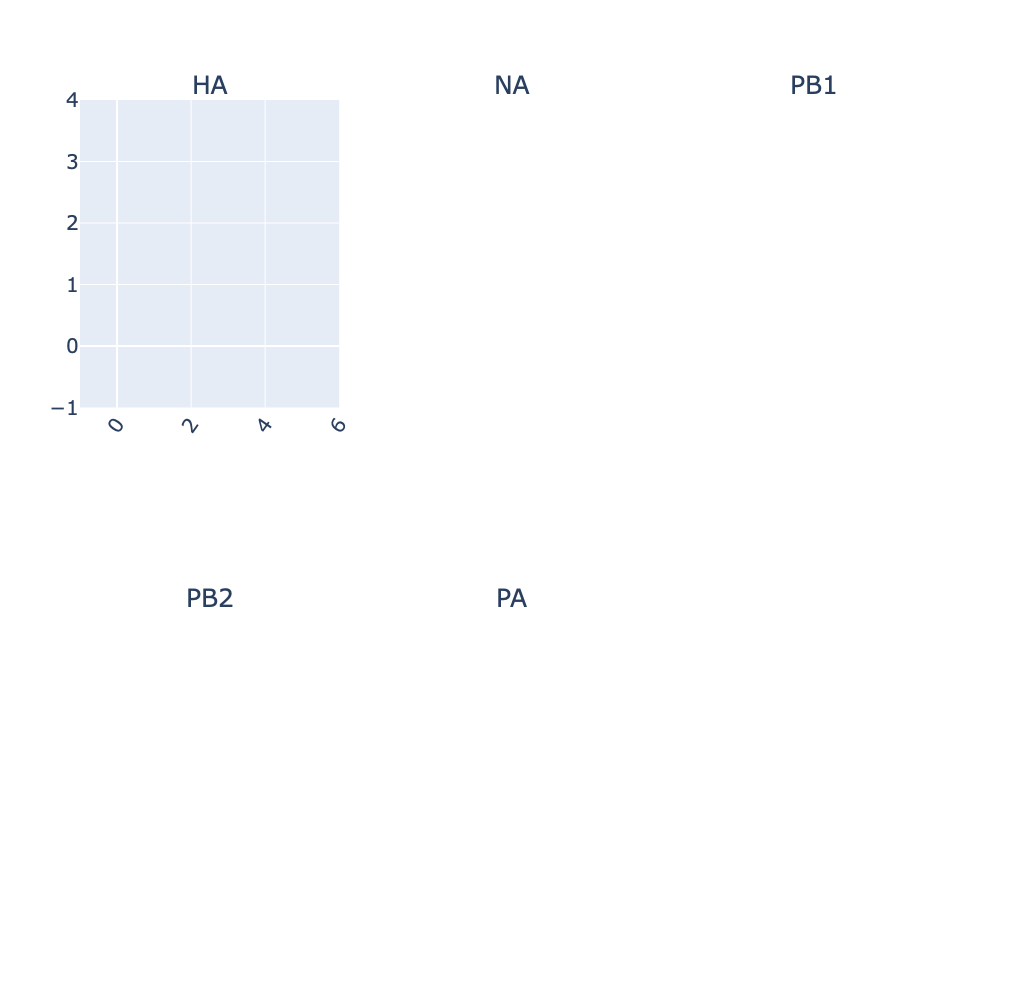

In [15]:
gene_order_map = [
    "HA",
    "NA",
    "PB1",
    "PB2",
    "PA"
]

color_and_host_order_map = {
    'Canine\nH3N2': 'saddlebrown',
    
}

# Mapping new columns
df_to_use = df_all.copy()

df_to_use['color'] = df_to_use['host'].map(color_and_host_order_map)
df_to_use["host_order"] = df_to_use["host"].map({host:idx for idx,host in enumerate(color_and_host_order_map.keys())}).fillna(float("inf"))
df_to_use["gene_order"] = df_to_use["gene"].map({gene:idx for idx,gene in enumerate(gene_order_map)}).fillna(float("inf"))
df_to_use.sort_values(by=["host_order", "gene_order"], inplace=True)

# genes = df_to_use["gene"].unique()
genes = [element.upper() for element in ['HA', 'NA', 'PB1', 'PB2', 'PA']]
hosts = [element.upper() for element in [
    'Canine\nH3N2'

]]
number_of_cols = 3
number_of_plots = len(genes)
number_of_rows = math.ceil(number_of_plots/number_of_cols)

print(df_to_use)


fig = make_subplots(
    subplot_titles=genes,
    rows=number_of_rows, 
    cols=number_of_cols,
    shared_yaxes='all',
    vertical_spacing=0.25,
    horizontal_spacing = 0.05
)

for idx, gene in enumerate(genes):
    subset_df = df_to_use[df_to_use["gene"] == gene]
    
    row_idx = idx % number_of_rows + 1
    column_idx = idx % number_of_cols + 1
    
    for host in hosts:
        sub_subset_df = subset_df[subset_df["host"].str.upper() == host]
        print(sub_subset_df)
        if sub_subset_df.empty:
            # raise RuntimeError(f"Host: {host} was not present in gene: {gene}")
            continue
        
        fig.add_trace(
            go.Scatter(
                x=sub_subset_df["host"], 
                y=sub_subset_df["adaptive_subs_per_codon_per_year"],
                name=host,
                text=gene,
                marker=dict(
                    color=sub_subset_df["color"].values[0],
                    size=10
                ),
                mode = "markers",
                error_y=dict(
                    type = 'data',
                    array = sub_subset_df["upper_95ci"] - sub_subset_df["adaptive_subs_per_codon_per_year"],
                    arrayminus = sub_subset_df["adaptive_subs_per_codon_per_year"] - sub_subset_df["lower_95ci"],
                    visible = True,
                    color = sub_subset_df["color"].values[0],
                    width=0,
                    thickness=3
                ),
                legendgroup=host,
                showlegend= idx == 1
            ),
            #where it adds data
            row = row_idx, 
            col = column_idx
        )
        
    #this makes the tick labels show for all plots
    getattr(fig.layout, 'yaxis' if idx == 0 else f'yaxis{idx}').showticklabels = True


    #this makes the title appear next to each row
    # if row_idx == 1:
    #     getattr(fig.layout, 'yaxis' if idx == 0 else f'yaxis{idx}').title = r'Adaptive Muts per Codon<br>per Year (x10^-3)'
        
fig.update_annotations(font_size=25)
            
fig.update_layout(
    font_size=18,
    width=1600,
    height=1000
)
fig.update_xaxes(tickangle=-55, tickfont_size=20)
fig.update_yaxes(tickfont_size=20)
fig.add_hline(y=1.17, line_width=1, line_dash="dash", line_color="black")
    
fig.show()

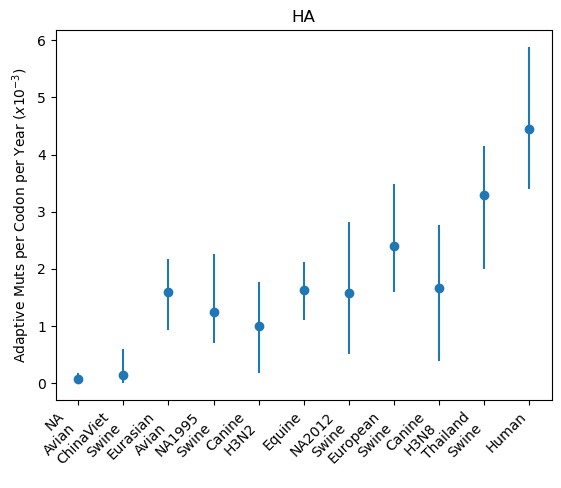

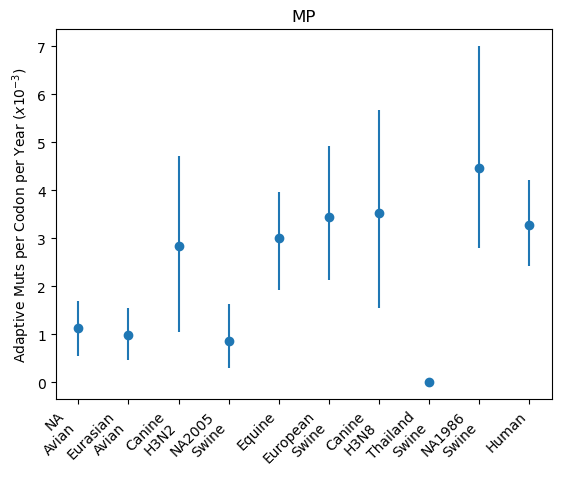

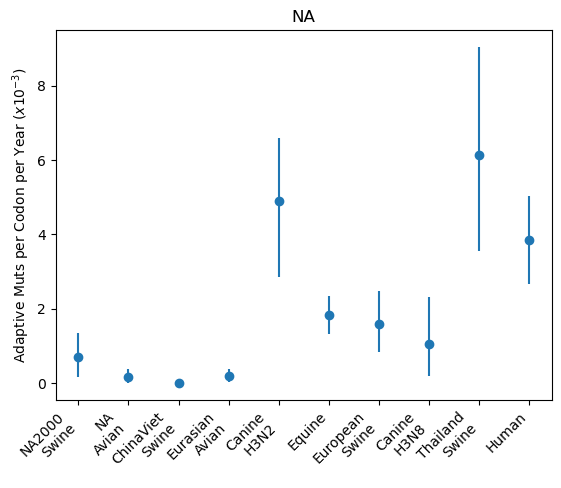

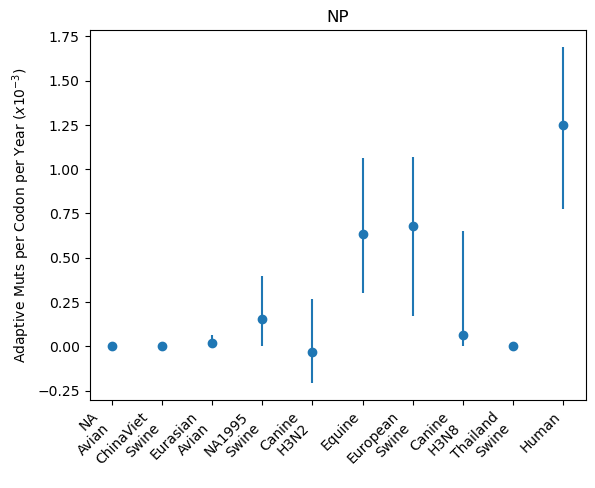

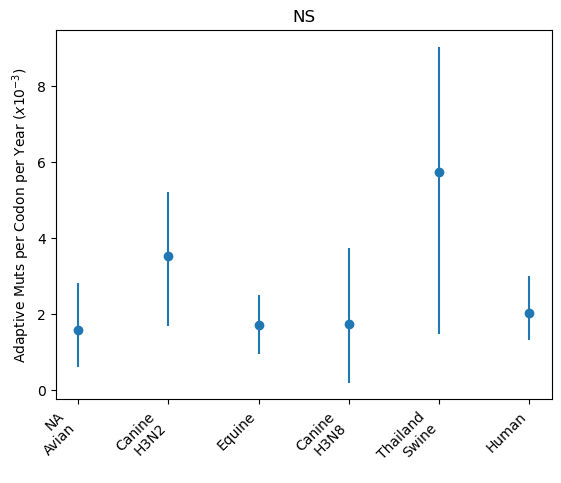

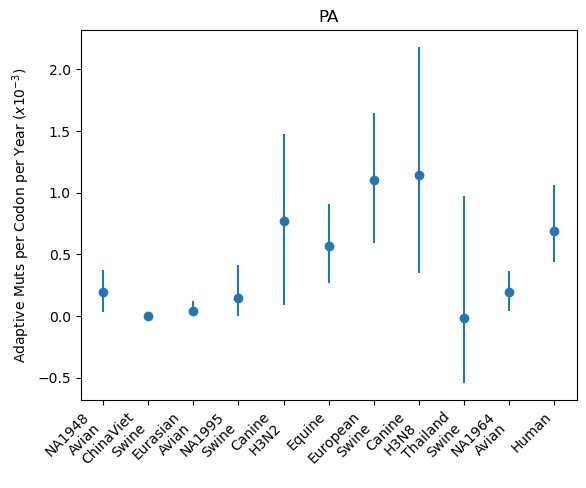

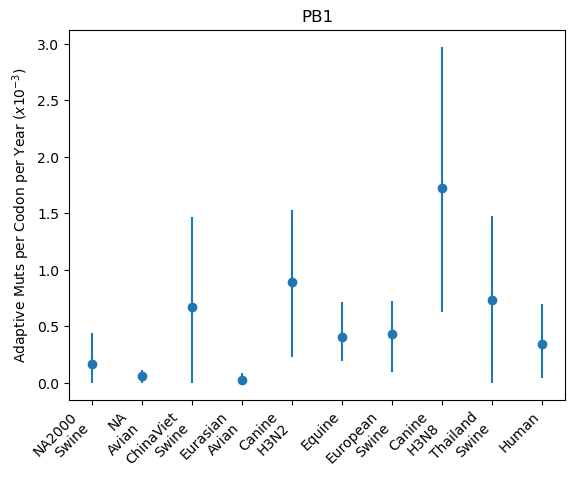

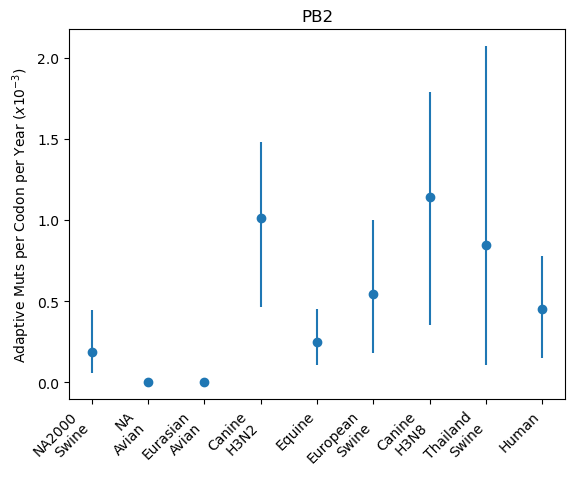

In [512]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


main_folder = '/Users/monclalab1/Documents/nonhuman_H3_project/non-human-h3/baltic_MK_scripts/adaptation_results/results'
host_folders = [folder for folder in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, folder))]


all_genes = []
all_hosts = []
all_slopes = []
all_lower_95cis = []
all_upper_95cis = []


for host_folder in host_folders:
    host_path = os.path.join(main_folder, host_folder)


    json_files = [file for file in os.listdir(host_path) if file.endswith('.json')]


    for json_file in json_files:
        json_path = os.path.join(host_path, json_file)


        with open(json_path, 'r') as file:
            data = json.load(file)


        rate_of_adaptation = data["rate_of_adaptation"]
        bootstrap_rate_of_adaptation = data["bootstrap_rate_of_adaptation"]

        slope_sci = rate_of_adaptation * (10**3)
        bs_slope_sci = [x * (10**3) for x in bootstrap_rate_of_adaptation]
        lower_95ci = np.percentile(sorted(bs_slope_sci), 2.5)
        upper_95ci = np.percentile(sorted(bs_slope_sci), 97.5)


        all_genes.append(data['gene'].upper()) 
        all_hosts.append(data['host'].replace(' ', '\n'))
        all_slopes.append(slope_sci)
        all_lower_95cis.append(lower_95ci)
        all_upper_95cis.append(upper_95ci)


all_data = {
    'gene': all_genes,
    'host': all_hosts,
    'adaptive_subs_per_codon_per_year': all_slopes,
    'lower_95ci': all_lower_95cis,
    'upper_95ci': all_upper_95cis,
    'ci': list(zip(all_lower_95cis, all_upper_95cis)),
}

df_all = pd.DataFrame(all_data)

for gene, group_df in df_all.groupby('gene'):
    fig, axs = plt.subplots(sharey=True)
    axs.errorbar(group_df['host'], group_df['adaptive_subs_per_codon_per_year'],
                yerr=[group_df['adaptive_subs_per_codon_per_year'] - group_df['lower_95ci'], group_df['upper_95ci'] - group_df['adaptive_subs_per_codon_per_year']],
                fmt='o')

    axs.set_ylabel(r'Adaptive Muts per Codon per Year $(x 10^{-3})$')
    axs.set_title(gene)
    axs.set_xticks(range(len(group_df['host'])))
    axs.set_xticklabels(group_df['host'], rotation=45, ha='right')
    plt.show()
